In [1]:
import pickle
import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ExponentialGaussianModel

from dltools.cov.markup import compute

In [4]:
df = pd.read_excel("Data/Compare KERs and angles.xlsx", sheet_name="Exp KERs")
df.head()

,Target,Value (eV),Std (eV),Note
0,"C1p,I1p,I1p",18.708615,8.703765,NaN
1,"C1p,I2p,I1p",27.487558,9.480627,NaN
2,"C1p,I2p,I2p",40.045890,11.788738,NaN
3,"C1p,I3p,I1p",43.758264,17.697372,NaN
4,"C1p,I3p,I2p",54.972187,11.750165,NaN


In [9]:
def gen():
    for target in df["Target"].unique():
        if target.startswith("C1p"):
            filename = f"Data/Cov ang dist and KER at the low int group; target={target}.pickle"
            with open(filename, "rb") as fp:
                d = pickle.load(fp)
        else:
            filename = ("Data/Cov ang dist and KER at the low int group; "
                        f"target={target} & h0phi=-135--120.pickle")
            with open(filename, "rb") as fp:
                d = pickle.load(fp)

        xkey, ykey = "ke", "sumke"
        n = d["N"]
        dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
        x = d["Cov[X,Y,Z]"][xkey] + dx / 2
        where = 0 < d["Sum[XYZ]"][ykey]

        avg = np.average(x[where], weights=d["Cov[X,Y,Z]"][ykey][where])
        std = np.average((x[where] - avg) ** 2, weights=d["Cov[X,Y,Z]"][ykey][where]) ** 0.5
        yield {
            "Target": target,
            "Value (eV)": avg,
            "Std (eV)": std,
            "Where max (eV)": x[d["Cov[X,Y,Z]"][ykey].argmax()].values.tolist(),
        }


read = pd.DataFrame(list(gen()))
read.head()

,Std (eV),Target,Value (eV),Where max (eV)
0,8.703765,"C1p,I1p,I1p",18.708615,15.5
1,9.480627,"C1p,I2p,I1p",27.487558,23.5
2,11.788738,"C1p,I2p,I2p",40.045890,36.5
3,17.697372,"C1p,I3p,I1p",43.758264,35.5
4,11.750165,"C1p,I3p,I2p",54.972187,49.5


40.4225996562204 ± 21.2214299109143


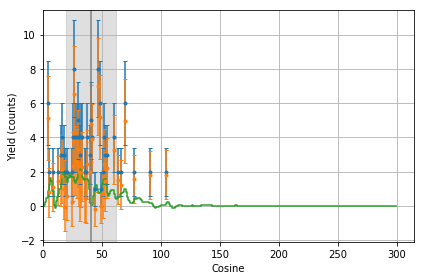

In [12]:
# filename = "Data/Cov ang dist and KER at the low int group; target=C1p,I6p,I5p.pickle"
filename = "Data/Cov ang dist and KER at the low int group; target=C2p,I1p,I1p & h0phi=-135--120.pickle"
with open(filename, "rb") as fp:
    d = pickle.load(fp)

xkey, ykey = "ke", "sumke"
n = d["N"]
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
x = d["Cov[X,Y,Z]"][xkey] + dx / 2
where = 0 < d["Sum[XYZ]"][ykey]

avg = np.average(x[where], weights=d["Cov[X,Y,Z]"][ykey][where])
std = np.average((x[where] - avg) ** 2, weights=d["Cov[X,Y,Z]"][ykey][where]) ** 0.5
print(f"{avg} ± {std}")

plt.figure()
plt.xlabel("Cosine")
plt.ylabel("Yield (counts)")
plt.errorbar(
    x[where],
    d["Sum[XYZ]"][ykey][where],
    d["Sum[XYZ]"][ykey][where] ** 0.5,
    fmt=".",
    capsize=2,
    label="Cov",
)
plt.errorbar(
    x[where],
    d["Cov[X,Y,Z]"][ykey][where] * n,
    d["Err[Cov[X,Y,Z]]"][ykey][where] * n,
    fmt=".",
    capsize=2,
    label="Cov",
)
plt.step(x, d["Sum[XYZ]"][ykey] - d["Cov[X,Y,Z]"][ykey] * n, where="mid")
plt.axvline(avg, color="grey")
if np.isfinite(std):
    plt.axvspan(avg - std, avg + std, alpha=0.25, color="grey")
plt.xlim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()